# Flugpreis Vorhersage - Kaufen oder Warten?
## Projektarbeit Data Mining
___
### Wintersemester 2021/22
### Gruppe G:
Max Grundmann - s0559326
### Inhalte
1. Exploratory Data Analysis (EDA)
2. Datenvorbereitung
### 3. Modelauswahl
4. Testing
___
Dieses Notebook widmet sich der Auswahl von zwei geeigneten Machine Learning Modellen und deren Hyperparametertuning.
___

#### Benötigte Bibliotheken laden

In [1]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import os
from random import sample
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.utils import compute_class_weight

from xgboost import XGBClassifier

from tensorflow import keras
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping

#### Vorbereitete Daten laden

In [7]:
n = 15

dirname = os.getcwd()
filename = os.path.join(dirname, f'../Data/prepped/train_set_n{n}.csv')

try:
    training_data = pd.read_csv(filename, index_col=0)
except FileNotFoundError as e:
    print('Datei konnte nicht gefunden werden.')

Daten in Trainings- und Testdaten aufteilen.
80% Trainingsdaten, 20% Testdaten
Stratify = Yes stellt außerdem sicher, dass das Verhältnis der Klassen in beiden Datensätzen gleich ist.

In [67]:
# Daten in Trainings- und Testdaten aufteilen
y = training_data['buy']
X = training_data.drop(columns=['buy'], axis=1)
X.columns = X.columns.map(str)

for i in range(n):
    X[str(i)] = np.where(X[str(i)].isnull(), X.Price_In_Eur, X[str(i)])

X = X.fillna(0)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99, stratify=y)

#### Auswahl eines ML-Verfahrens

Folgenden Methode dient dem Automatisierten Training und Evaluierung eines ML-Modells. Ziel ist es, eine Baseline für mehrere unterschiedliche Verfahren zu etablieren. Das beste Modell wird anschließend über Hyperparameter Tuning weiter optimiert.

In [20]:
def evaluate_model(model, x_train, y_train, x_test, y_test, fit=True):
    if fit:
        model = model.fit(x_train, y_train)
    
    print('Training Score:', model.score(x_train, y_train))
    
    predicted = pd.DataFrame(model.predict(x_test))
    
    print('Test Score:', metrics.accuracy_score(y_test, predicted))
    
    print(metrics.classification_report(y_test, predicted))
    return model.score(x_train, y_train), metrics.accuracy_score(y_test, predicted)

Die Support Vector Machine wurde im weiteren Vorgehen nicht berücksichtigt, da die Trainingszeiten unverhältnismäßig lag dauern. Das dürfte darin begründet liegen, dass die Trainingskomplexität einer SVM bei O(n^2) liegt und entsprechend stark bzw. schlecht mit der Anzahl an Trainingsdaten skaliert. Entsprechend limitiert vermutlich auch mein Arbeitsspeicher die Berechnung.

In [26]:
list_of_models = [RandomForestClassifier(), 
                # SVC(kernel='linear'), 
                  XGBClassifier(),
                  AdaBoostClassifier(),
                  GradientBoostingClassifier(),
                  tree.DecisionTreeClassifier(max_depth=10), 
                  LogisticRegression(), 
                  BaggingClassifier(),
                  KNeighborsClassifier(n_neighbors=5), 
                  GaussianNB()]

scores = {}

for model in list_of_models:
    print(str(model)[:13])
    train_acc, test_acc = evaluate_model(model, x_train, y_train, x_test, y_test)
    scores[str(model)[:13]] = {'train_accurary' : train_acc, 'test_accuracy': test_acc}
    print('-------------------------------------------------------------------------------')

RandomForestC
Training Score: 0.9998953646541802
Test Score: 0.9100149476831091
              precision    recall  f1-score   support

           0       0.91      0.98      0.94     12981
           1       0.90      0.67      0.77      3744

    accuracy                           0.91     16725
   macro avg       0.91      0.82      0.86     16725
weighted avg       0.91      0.91      0.90     16725

-------------------------------------------------------------------------------
XGBClassifier
[12:32:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Max\Anaconda3\envs\py39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Training Score: 0.9311648903571055
Test Score: 0.8916591928251121
              precision    recall  f1-score   support

           0       0.90      0.96      0.93     12981
           1       0.84      0.64      0.73      3744

    accuracy                           0.89     16725
   macro avg       0.87      0.80      0.83     16725
weighted avg       0.89      0.89      0.89     16725

-------------------------------------------------------------------------------
AdaBoostClass
Training Score: 0.8275310542758487
Test Score: 0.8243946188340807
              precision    recall  f1-score   support

           0       0.84      0.95      0.89     12981
           1       0.70      0.38      0.49      3744

    accuracy                           0.82     16725
   macro avg       0.77      0.67      0.69     16725
weighted avg       0.81      0.82      0.80     16725

-------------------------------------------------------------------------------
GradientBoost
Training Score: 0.84289750

C:\Users\Max\Anaconda3\envs\py39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Score: 0.81365939700145
Test Score: 0.8123766816143497
              precision    recall  f1-score   support

           0       0.83      0.96      0.89     12981
           1       0.68      0.30      0.42      3744

    accuracy                           0.81     16725
   macro avg       0.75      0.63      0.65     16725
weighted avg       0.79      0.81      0.78     16725

-------------------------------------------------------------------------------
BaggingClassi
Training Score: 0.9945739099239151
Test Score: 0.9066068759342302
              precision    recall  f1-score   support

           0       0.91      0.97      0.94     12981
           1       0.88      0.68      0.76      3744

    accuracy                           0.91     16725
   macro avg       0.90      0.82      0.85     16725
weighted avg       0.90      0.91      0.90     16725

-------------------------------------------------------------------------------
GaussianNB()
Training Score: 0.77709681759

In [42]:
results = pd.DataFrame(scores).transpose()
results.rename(columns={'index': 'model'},  inplace=True)
results.sort_values(by=['test_accuracy'], axis=0, ascending=False, inplace=True)
results

,train_accurary,test_accuracy
RandomForestC,0.999895,0.910015
BaggingClassi,0.994574,0.906607
XGBClassifier,0.931165,0.891659
DecisionTreeC,0.857591,0.839402
GradientBoost,0.842898,0.838386
AdaBoostClass,0.827531,0.824395
LogisticRegre,0.813659,0.812377
GaussianNB(),0.777097,0.776682


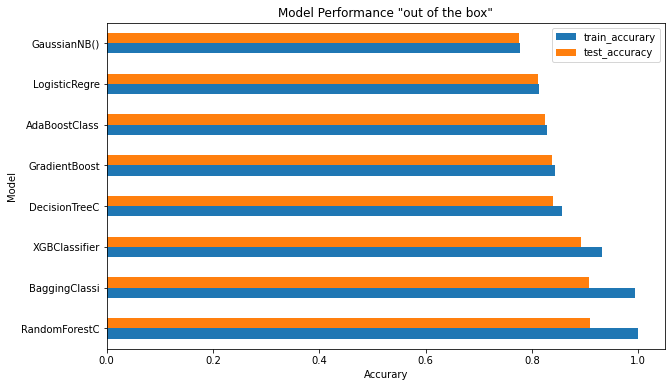

In [44]:
plt.rcParams["figure.figsize"] = [10, 6]

results.plot(kind='barh')
plt.title('Model Performance "out of the box"')
plt.ylabel("Model")
plt.xlabel("Accurary")
plt.savefig("../Ressources/model_performance_comp.png", edgecolor='white')

#### Cross-Validation Baseline

Zusätzlich habe ich nochmal die vier vielversprechendsten Classifier mit Kreuzvalidierung getestet.

In [45]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [46]:
def performCrossValidation(model, x_train, y_train, splits=5):
    print(f'{str(model)[:13]} mit splits={splits}')
    cv = RepeatedStratifiedKFold(n_splits=splits, n_repeats=3, random_state=1)
    return cross_val_score(model, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

In [47]:
display_scores(performCrossValidation(RandomForestClassifier(), x_train, y_train))

RandomForestC mit splits=5
Scores: [0.90747384 0.90358744 0.9103139  0.90568012 0.90350549 0.90627803
 0.90089686 0.90769806 0.90508221 0.90679423 0.90754858 0.9073991
 0.90418535 0.90216741 0.9077659 ]
Mean: 0.9057584358028165
Standard deviation: 0.0024218930528767243


In [48]:
display_scores(performCrossValidation(BaggingClassifier(), x_train, y_train))

BaggingClassi mit splits=5
Scores: [0.9058296  0.89828102 0.90523169 0.90179372 0.89775021 0.90351271
 0.89753363 0.90201794 0.90127055 0.90066522 0.90239163 0.90007474
 0.90007474 0.90059791 0.90380447]
Mean: 0.9013886508216086
Standard deviation: 0.0024327888943376074


In [49]:
display_scores(performCrossValidation(XGBClassifier(), x_train, y_train))

XGBClassifier mit splits=5
Scores: [0.89394619 0.88856502 0.88811659 0.88527653 0.8928171  0.8887145
 0.89080717 0.88998505 0.89050822 0.89042529 0.89043348 0.89424514
 0.88908819 0.88834081 0.88780925]
Mean: 0.8899385702623224
Standard deviation: 0.0023195638820190964


In [50]:
display_scores(performCrossValidation(tree.DecisionTreeClassifier(max_depth=10), x_train, y_train))

DecisionTreeC mit splits=5
Scores: [0.84297459 0.84446936 0.84431988 0.8357997  0.84206592 0.84125561
 0.84080717 0.84252616 0.84050822 0.84602736 0.84387145 0.84020927
 0.8416293  0.84237668 0.84453248]
Mean: 0.842224876062565
Standard deviation: 0.0023695217789564196


### Hyperparameter Tuning eines Random Forest Classifiers

Im einem Vergleich ohne jegliches Hyperparameter Tuning hat der Random Forest Classifier für den Datensatz die höchste Test-Genauigkeit erzielt. Allerdings hat sich bereits dort gezeigt, dass der Classifier ohne weiteres Tuning stark zum overfitting neigt, was an einer Trainingsgenauigkeit von 99% deutlich wird. Für das weitere Tuning wird daher eine K-Fold Cross-Validation mit K=5 durchgeführt.

Da die beiden Klassen Kaufen und Warten sehr ungleich verteilt sind, würde ein naives Modell, das nur Warten vorhersagt, bereits eine Accuracy von 77,6% erreichen. Um dem entgegen zuwirken, berechne ich hier die Gewichtung der beiden Klassen, um diese dem Modell übergeben zu können.

In [18]:
classWeight = compute_class_weight(class_weight = 'balanced', 
                                   classes=np.unique(y),
                                    y=y)
classWeight = dict(enumerate(classWeight))

#### Grid Search für Random Forrest Classfier

Aus Performance-Gründen habe ich die finale Grid-Suche auf einer Google Colab Instanz laufen lassen, daher entsprechen die hier ausgegebenen Outputs nicht unbedingt dem finalen Model.

In [16]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# rf_random = RandomizedSearchCV(estimator = rf, 
#                                param_distributions = random_grid, 
#                                n_iter = 100, 
#                                cv = 3, 
#                                verbose=2, 
#                                random_state=42, 
#                                n_jobs = -1)

# rf_random.fit(x_train, y_train)
# rf_random.best_params_

In [32]:
random_grid = {'n_estimators': [50, 200, 400],
               'max_features': ['auto', 0.25, 0.5, 1.0],
               'max_depth': [4, 8,16],
               'min_samples_split': [2, 5, 10],
            #    'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=1)

rf = RandomForestClassifier(class_weight=classWeight)

rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 2, 
                               cv = 2, 
                               verbose=99, 
                               random_state=42,
                               scoring='accuracy',
                               n_jobs = -1,
                               refit=True)

model = rf_random.fit(x_train, y_train)
rf_random.best_params_

NameError: name 'bootstrap' is not defined

In [15]:
evaluate_model(model, x_train, y_train, x_test, y_test, fit=False)

C:\Users\Max\Anaconda3\envs\py39\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- price_of_previous_flight
Feature names seen at fit time, yet now missing:
- price_of_next_flight

  warnings.warn(message, FutureWarning)


Training Score: 0.2861029312844736
Test Score: 0.2898654708520179
              precision    recall  f1-score   support

           0       0.77      0.12      0.21     12981
           1       0.22      0.87      0.36      3744

    accuracy                           0.29     16725
   macro avg       0.50      0.50      0.28     16725
weighted avg       0.65      0.29      0.24     16725



C:\Users\Max\Anaconda3\envs\py39\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- price_of_previous_flight
Feature names seen at fit time, yet now missing:
- price_of_next_flight

  warnings.warn(message, FutureWarning)
C:\Users\Max\Anaconda3\envs\py39\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- price_of_previous_flight
Feature names seen at fit time, yet now missing:
- price_of_next_flight

  warnings.warn(message, FutureWarning)


(0.2861029312844736, 0.2898654708520179)

In [24]:
model_save_path = '../Models/final_models/random_forest_v5.pkl'
pickle.dump(rf_random, open(model_save_path, 'wb'))

In [54]:
# Auf Google Colab trainiertes Modell laden
rf_model = pickle.load(open('../Models/final_models/random_forest_v4.pkl', 'rb'))

In [55]:
evaluate_model(rf_model, x_train, y_train, x_test, y_test, fit=False)

Training Score: 0.9862030822583298
Test Score: 0.986846038863976
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     12981
           1       0.98      0.96      0.97      3744

    accuracy                           0.99     16725
   macro avg       0.98      0.98      0.98     16725
weighted avg       0.99      0.99      0.99     16725



(0.9862030822583298, 0.986846038863976)

#### AUC Kurve plotten

C:\Users\Max\Anaconda3\envs\py39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


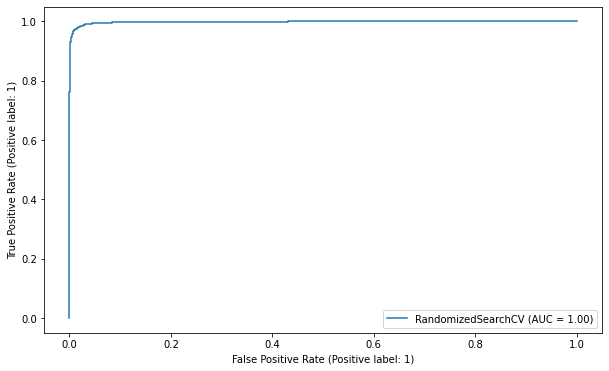

In [56]:
plt.rcParams["figure.figsize"] = [10, 6]
metrics.plot_roc_curve(rf_model, x_test, y_test) 

In [70]:
display_scores(performCrossValidation(rf_model, x_train, y_train))

RandomizedSea mit splits=5


KeyboardInterrupt: 

In [ ]:
rf_model.best_params_

{'n_estimators': 50,
 'min_samples_split': 5,
 'max_features': 0.5,
 'max_depth': 16,
 'bootstrap': False}

In [104]:
new_rf = RandomForestClassifier(n_estimators= 150,
 min_samples_split= 10,
 max_features=0.65,
 max_depth= 32,
 n_jobs=-1,
 bootstrap= False,
 class_weight=classWeight)
 
new_rf.fit(x_train, y_train)
evaluate_model(new_rf, x_train, y_train, x_test, y_test, fit=False)

Training Score: 0.9988041674763449
Test Score: 0.9304633781763827
              precision    recall  f1-score   support

           0       0.95      0.96      0.96     12981
           1       0.87      0.81      0.84      3744

    accuracy                           0.93     16725
   macro avg       0.91      0.89      0.90     16725
weighted avg       0.93      0.93      0.93     16725



(0.9988041674763449, 0.9304633781763827)

### Finales Modell trainieren

In [69]:
new_rf = RandomForestClassifier(n_estimators= 150,
 min_samples_split= 8,
 max_features=0.5,
 max_depth= 32,
 bootstrap= False,
 class_weight=classWeight)
 
new_rf.fit(x_train, y_train)
evaluate_model(new_rf, x_train, y_train, x_test, y_test, fit=False)

Training Score: 0.9994020837381725
Test Score: 0.930762331838565
              precision    recall  f1-score   support

           0       0.94      0.97      0.96     12981
           1       0.88      0.80      0.84      3744

    accuracy                           0.93     16725
   macro avg       0.91      0.88      0.90     16725
weighted avg       0.93      0.93      0.93     16725



(0.9994020837381725, 0.930762331838565)

#### Feature Importance

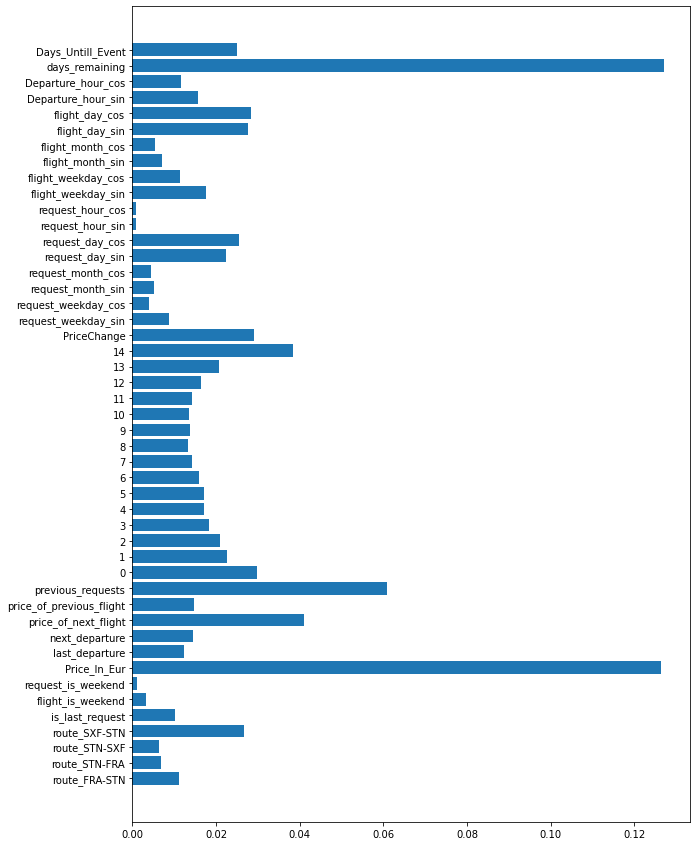

In [60]:
plt.rcParams["figure.figsize"] = [10, 15]
plt.barh(x_train.columns, new_rf.feature_importances_)
plt.savefig('../Ressources/rf_feature_importance.png')

In [62]:
pd.DataFrame(list(zip(new_rf.feature_importances_, x_train.columns))).sort_values(by=[0], ascending=False).head(10)

,0,1
45,0.127004,days_remaining
7,0.126435,Price_In_Eur
12,0.060902,previous_requests
10,0.040913,price_of_next_flight
27,0.038289,14
13,0.029781,0
28,0.029103,PriceChange
42,0.028403,flight_day_cos
41,0.027587,flight_day_sin
3,0.026582,route_SXF-STN


#### Cross Validation mit Hyperparameter Tuning

In [ ]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)

model = RandomForestClassifier(n_estimators= 200, 
                               max_features= 'sqrt')

scores = cross_val_score(model, x_train.drop(['request_is_weekend', 
                                              'request_month_sin', 
                                              'request_month_cos'],1), y_train, scoring='accuracy', cv=cv, n_jobs=-1)

model = model.fit(x_train, y_train)

In [ ]:
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

# Predictions on the test dataset
predicted = pd.DataFrame(model.predict(x_test))
# Probabilities on the test dataset
probs = pd.DataFrame(model.predict_proba(x_test))
print('Test Score:', metrics.accuracy_score(y_test, predicted))

print(metrics.classification_report(y_test, predicted))
print(model.feature_importances_)

___

## 3. Neural Network

Als zweiter Classifier habe ich ein neuronales Netzwerk gewählt. 

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/Data Mining/Models/'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

early_stopping = EarlyStopping(patience=9999, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=20, min_lr=0.00001, verbose=1)

print(classWeight)

history = model.fit(
    X, 
    y, 
    batch_size = 1024,
    validation_split=0.2,
    epochs=100, 
    class_weight=classWeight,
    callbacks=[early_stopping, reduce_lr, model_checkpoint_callback])
    

Epoch 1/200
2091/2091 [==============================] - 6s 2ms/step - loss: 0.5252 - accuracy: 0.7592 - val_loss: 0.3912 - val_accuracy: 0.8380
Epoch 2/200
2091/2091 [==============================] - 5s 2ms/step - loss: 0.4859 - accuracy: 0.7803 - val_loss: 0.3771 - val_accuracy: 0.8468
Epoch 3/200
2091/2091 [==============================] - 5s 2ms/step - loss: 0.4673 - accuracy: 0.7925 - val_loss: 0.3704 - val_accuracy: 0.8504
Epoch 4/200
2091/2091 [==============================] - 5s 2ms/step - loss: 0.4553 - accuracy: 0.7980 - val_loss: 0.3692 - val_accuracy: 0.8505
Epoch 5/200
2091/2091 [==============================] - 5s 2ms/step - loss: 0.4476 - accuracy: 0.7992 - val_loss: 0.3663 - val_accuracy: 0.8529
Epoch 6/200
2091/2091 [==============================] - 5s 2ms/step - loss: 0.4415 - accuracy: 0.8022 - val_loss: 0.3750 - val_accuracy: 0.8529
Epoch 7/200
2091/2091 [==============================] - 5s 2ms/step - loss: 0.4337 - accuracy: 0.8059 - val_loss: 0.3709 - val_ac

In [1]:
model

NameError: name 'model' is not defined

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history['val_loss'], 'r')
plt.xlabel('Epochs')
plt.ylabel('Validation score')
plt.show()

TypeError: 'History' object is not subscriptable

In [ ]:
pred = model.predict(x_test)

In [ ]:
print(metrics.classification_report(y_test, pred))

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

## 3. Feature Engineering

In [ ]:
n = 40

dirname = os.getcwd()
filename = os.path.join(dirname, f'../Data/prepped/test_set_n{n}.csv')

try:
    test_data = pd.read_csv(filename, index_col=0)
except FileNotFoundError as e:
    print('Datei konnte nicht gefunden werden.')

In [ ]:
# The model quality evaluation function expects a Pandas dataframe with at least the following columns:
# Request_Date          int64
# flight_unique_id     object
# Price               float64
# buy                    bool

def model_quality_evaluation(df):
    # Make a copy of the provided dataframe as to not modify the original.
    df = df.copy()

    # Convert 'Price' to whole cents and store as integers to avoid floating point errors.
    df['Price'] = df['Price'] * 100
    df['Price'] = df['Price'].astype(int)

    # Initialize a variable that stores the sum of all our balances.
    sum_balances = 0

    # Get a list of all 'flight_unique_id'.
    flight_unique_ids = df['flight_unique_id'].unique()

    # Iterate over all 'flight_unique_id'.
    for flight_unique_id in flight_unique_ids:
        # Get a subset of the data for the specified 'flight_unique_id'.
        df_subset = df[df['flight_unique_id'] == flight_unique_id]

        # Get all request dates except for the latest request date before departure.
        # At the latest request date before departure we need to buy a ticket anyway,
        # so we don't care about this specific request date.
        request_dates = df_subset[df_subset['Request_Date'] != df_subset['Request_Date'].max()]

        # Make sure request dates are sorted in descending order.
        request_dates.sort_values(by='Request_Date', ascending=False, inplace=True)

        # Get the ticket price from the latest request date before departure,
        # because we certainly have to buy a ticket at this date.
        last_buying_price = df_subset[df_subset['Request_Date'] == df_subset['Request_Date'].max()]['Price'].values[0]

        # Iterate over the remaining request dates
        for _, row in request_dates.iterrows():
            # and check wether the model wants to buy a ticket at the specific request date.
            if(row['buy'] == True):
                # If the model decides to buy a ticket the last buying price is set to the
                # price point of this request date and the balance doesn't change.
                last_buying_price = row['Price']
            else:
                # If the models decides to not buy a ticket the balance equals the
                # the current ticket price minus the last buying price.
                current_price = row['Price']
                balance = current_price - last_buying_price

                # The balance is added to the sum of all balances.
                sum_balances = sum_balances + balance

    # Return the sum of all our previously calculated balances.
    return sum_balances / 100

In [ ]:
model.predict(test_data)

NameError: name 'model' is not defined

In [ ]:
model_quality_evaluation(test_data)